## DIY: using python to process 4D STEM data


Developed by Stephanie Ribet, Dr. Roberto dos Reis and Dr. Paul Smeets
- [Dravid group](http://vpd.ms.northwestern.edu/)
- [NUANCE](http://www.nuance.northwestern.edu/)

Gatan Workshop: December 9, 2020

Data courtesy of Dr. Xiaobing Hu

packages 
- [skimage](https://scikit-image.org/)
- [ncempy](https://pypi.org/project/ncempy/)

### 1.  Load packages and data

In [1]:
#import necessary packages
%matplotlib nbagg

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

from scipy import ndimage
from scipy.spatial import distance

import math

from skimage import filters
from skimage.morphology import disk
from skimage import feature

from ncempy.io import dm

In [38]:
#load file using ncem's DM reader, other packages for loading data: hyperspy, h5py

filename='4D_data.dm4'
im0 = dm.dmReader (filename)
data = im0['data'][:]

In [39]:
#simplest virtual image and average diffraction pattern

virtualimage = np.average(data, axis=(2,3))
aveDP = np.average(data, axis=(0,1))

<IPython.core.display.Javascript object>


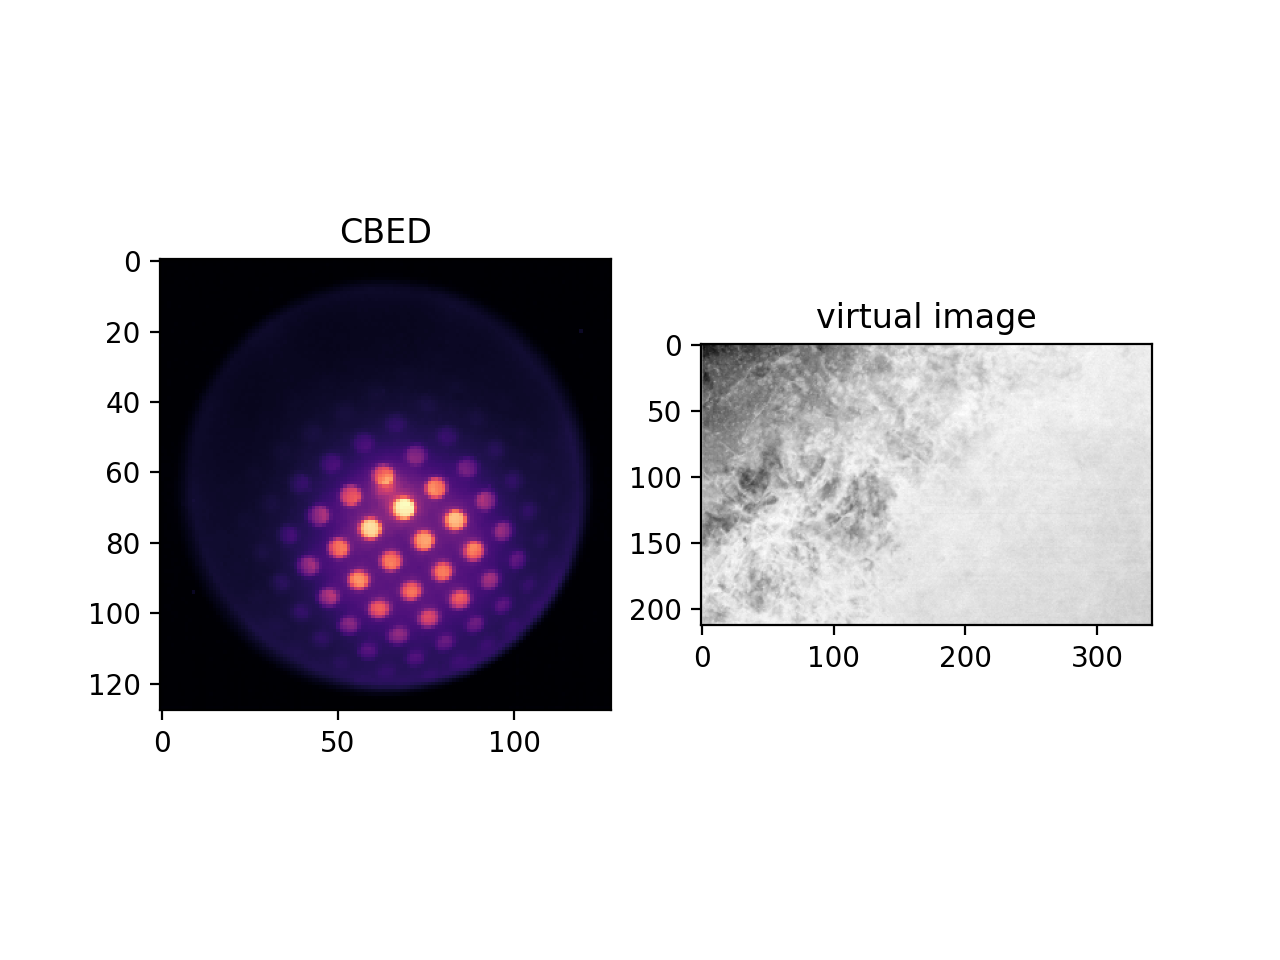

In [40]:
#plot virtual image and diffraction pattern

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(aveDP, cmap='magma')
ax[1].imshow(virtualimage, cmap='gray')

ax[0].set_title('CBED')
ax[1].set_title('virtual image')

plt.show()

### 2.  Reduce data size
- Binning data 
    - already done for this data set
    - appropriate degree of binning depends on dataset/reconstruction method
- Cropping 

In [5]:
data=data[:,:,27:127,20:120]

<IPython.core.display.Javascript object>


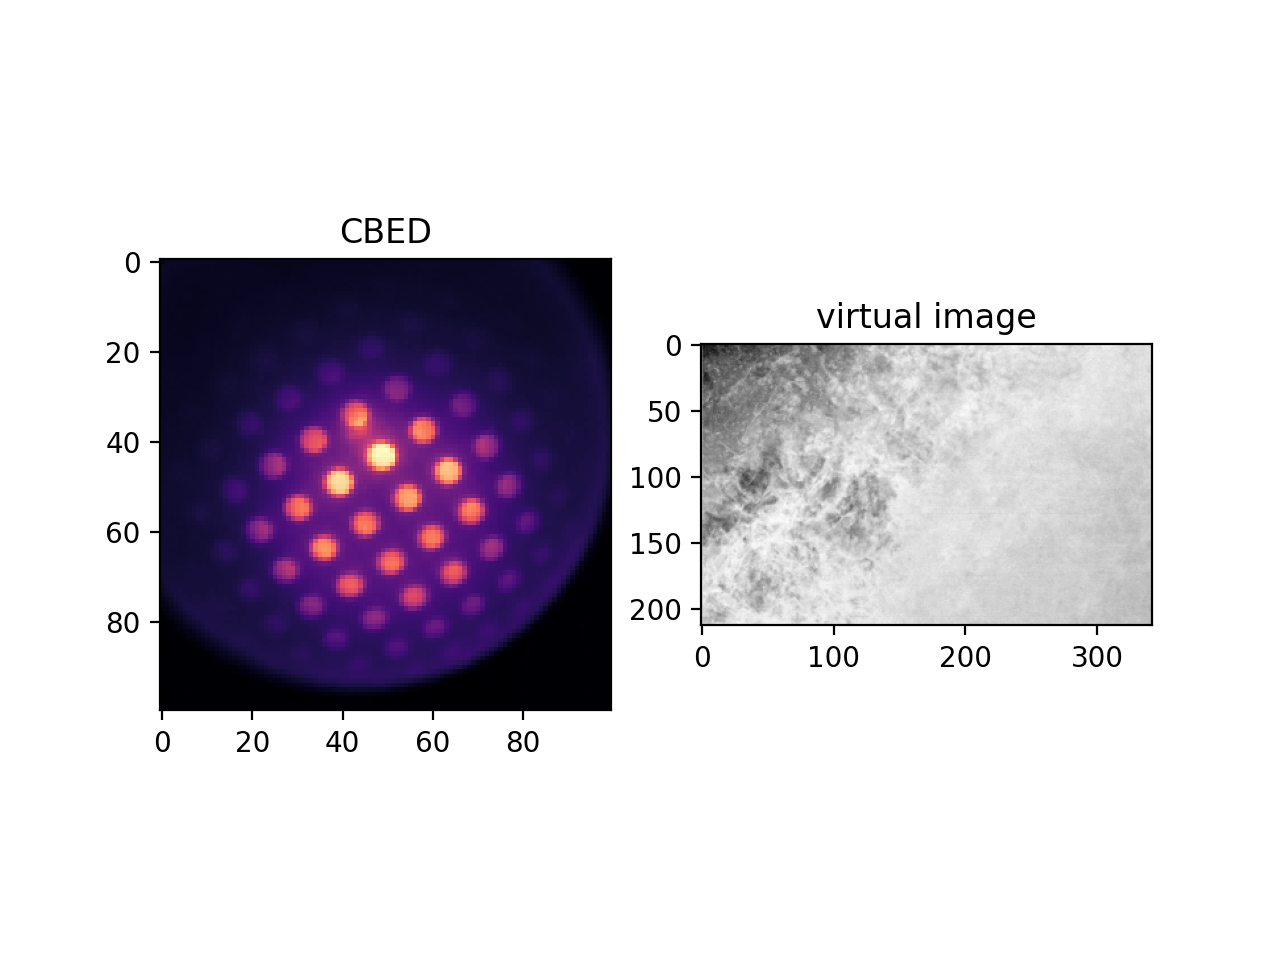

In [27]:
#check cropping 

virtualimage = np.average(data, axis=(2,3))
aveDP = np.average(data, axis=(0,1))

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(aveDP, cmap='magma')
ax[1].imshow(virtualimage, cmap='gray')

ax[0].set_title('CBED')
ax[1].set_title('virtual image')

plt.show()

### 3. Create virtual reconstructions
- Conventional BF, DF, ABF images can be reconstructed from scanning diffraction datasets.
- Detectors can be tailored to diffraction pattern to highlight specific phases. 
- First find center of diffraction pattern, then create masks for area of interest in diffraction space. 

In [28]:
#find center of diffraciton disk

blob=feature.blob_log(aveDP, min_sigma=3, max_sigma=6, threshold=69)

fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.scatter(blob[:,1], blob[:,0])
plt.show()

ic=blob[:,0]
jc=blob[:,1]

print("ic is " + str(ic))
print("jc is " + str(jc))

<IPython.core.display.Javascript object>

ic is [43.]
jc is [49.]


In [29]:
#create BF image

#create mask
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_BF = (x - ic) ** 2 + (y-jc) ** 2 < 4 ** 2

#plot mask over DP to check alignment 
fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.imshow(mask_BF, cmap='gray', alpha=0.5)
plt.show()

#initalize BF image
BF=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))

#integrate diffraction space to create BF image
for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_BF[i,j]:
            BF=BF+data[:,:,i,j]

<IPython.core.display.Javascript object>

In [30]:
#plot BF image 

fig,ax=plt.subplots()
ax.matshow(BF, cmap=plt.cm.gray)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


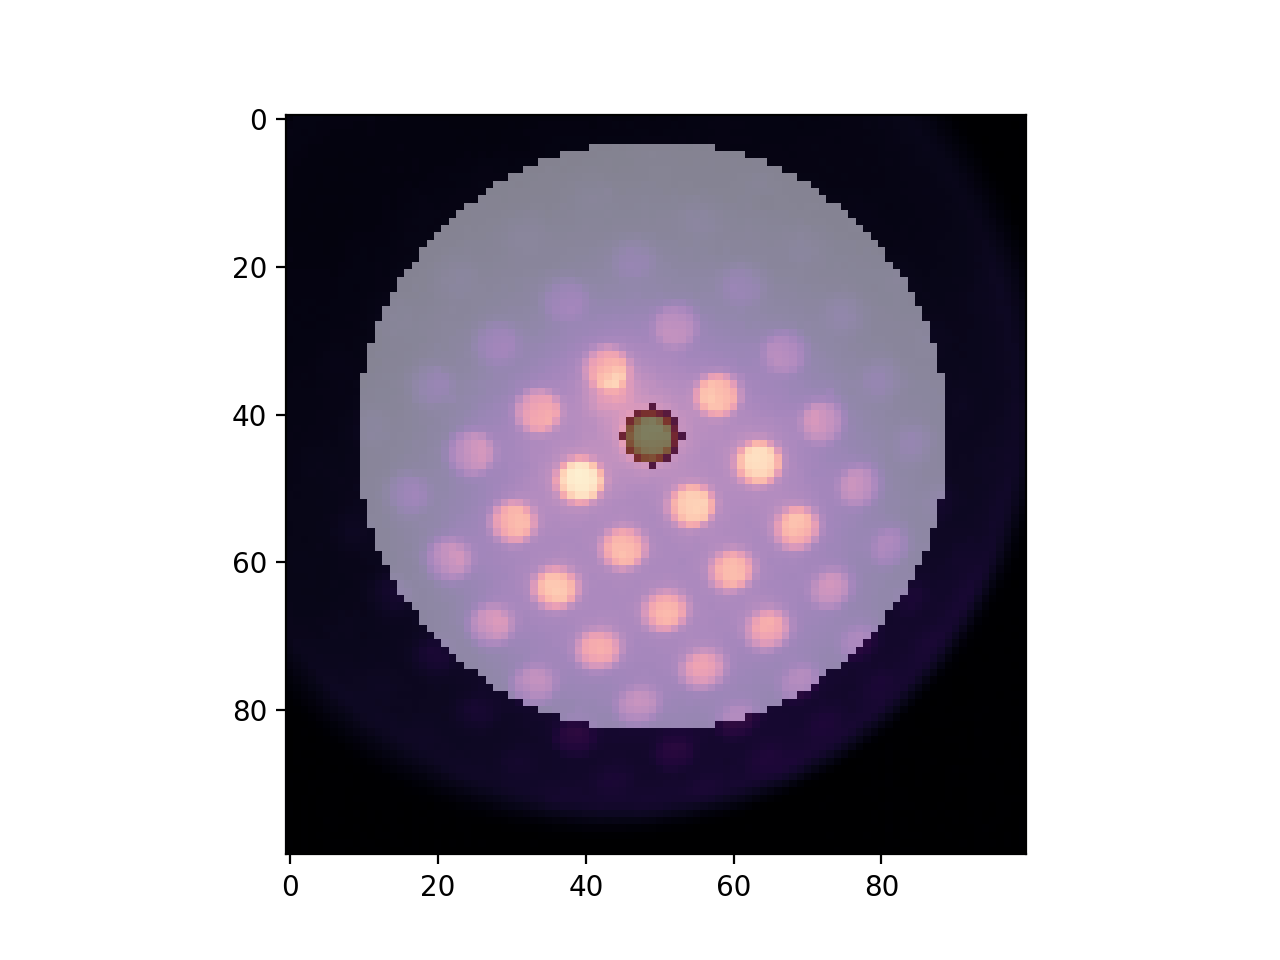

In [32]:
#create DF image

#create DF mask
mask1 = (x - ic) ** 2 + (y-jc) ** 2 > 4 ** 2
mask2 = (x - ic) ** 2 + (y-jc) ** 2 < 40 ** 2
mask_DF=np.logical_and(mask1, mask2) #use logical to create annular detector

#check mask
fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.imshow(mask_DF, cmap='gray', alpha=0.5)
plt.show()

#initialize DF image
DF=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))

#integrate to create DF image
for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_DF[i,j]:
            DF=DF+data[:,:,i,j]

<IPython.core.display.Javascript object>


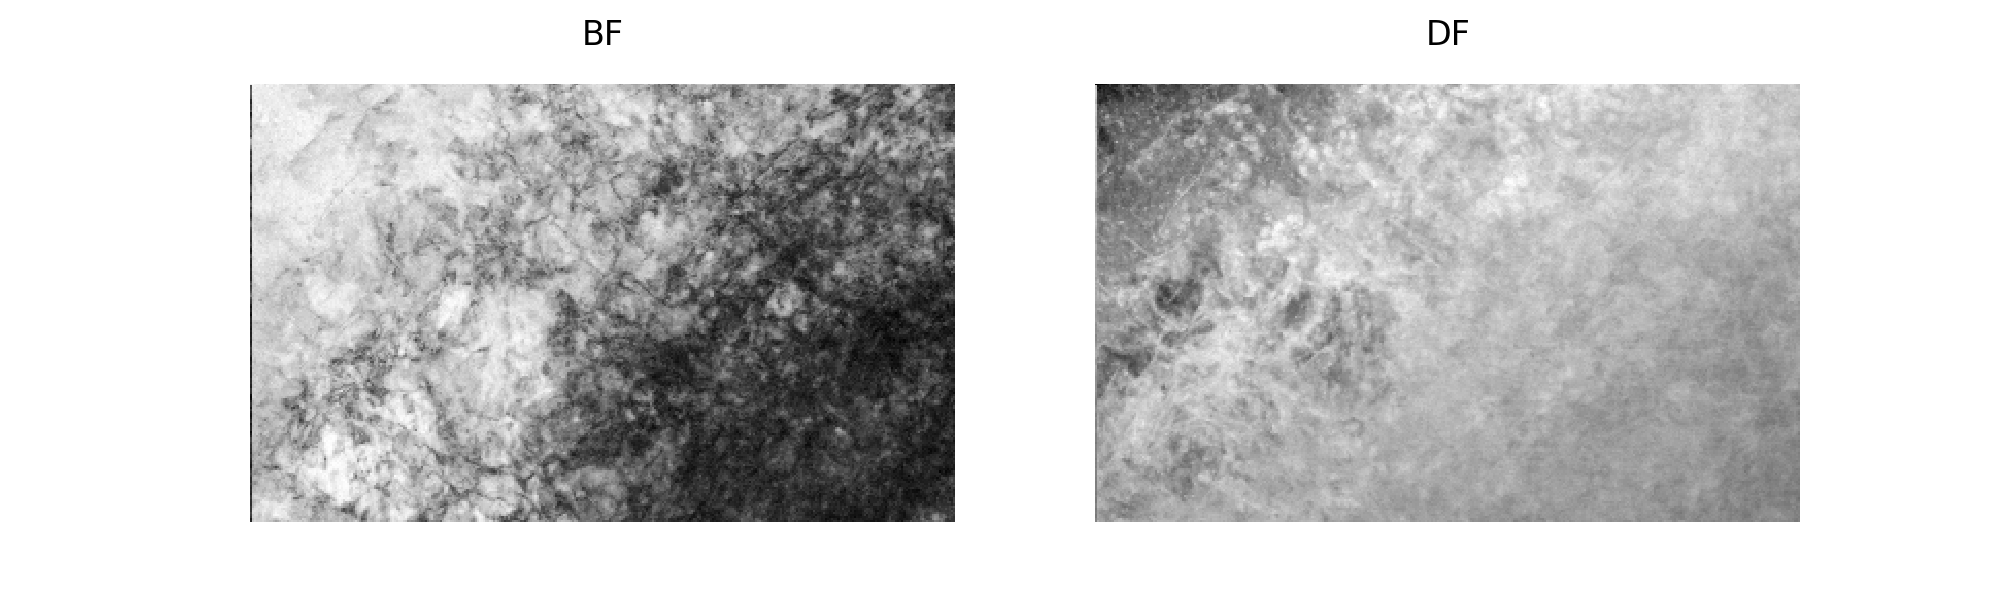

In [33]:
#compare BF and DF
fig,ax=plt.subplots(ncols=2, figsize=(10,3))
ax[0].matshow(BF, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('BF')


ax[1].matshow(DF, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('DF')

plt.show()

<IPython.core.display.Javascript object>


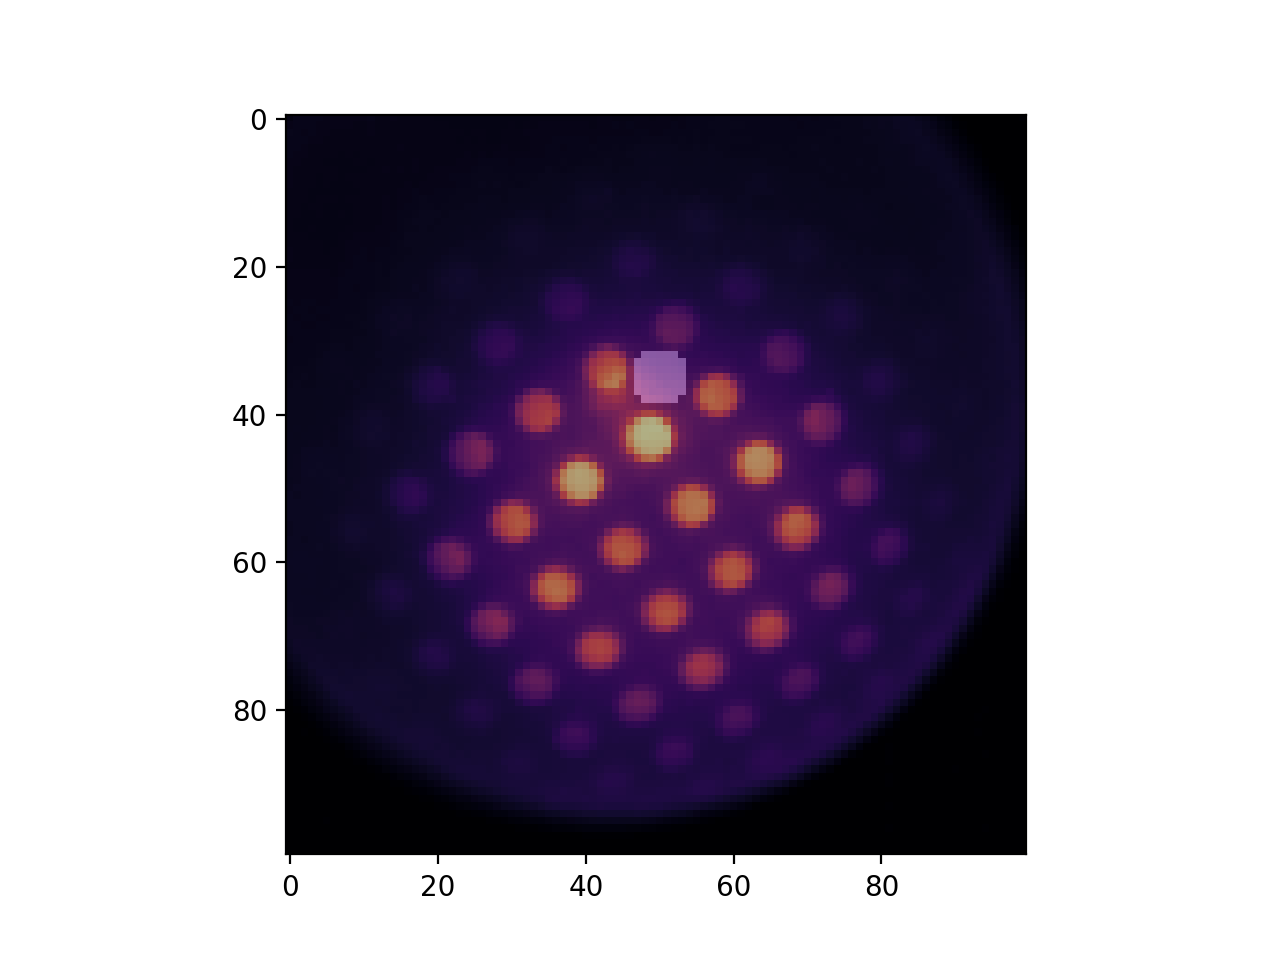

In [34]:
#check precipitate

x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_ppt = (x - 35) ** 2 + (y-50) ** 2 < 4 ** 2

ppt=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))

for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_ppt[i,j]:
            ppt=ppt+data[:,:,i,j]
            
fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.imshow(mask_ppt, cmap='gray', alpha=0.3)
plt.show()

<IPython.core.display.Javascript object>


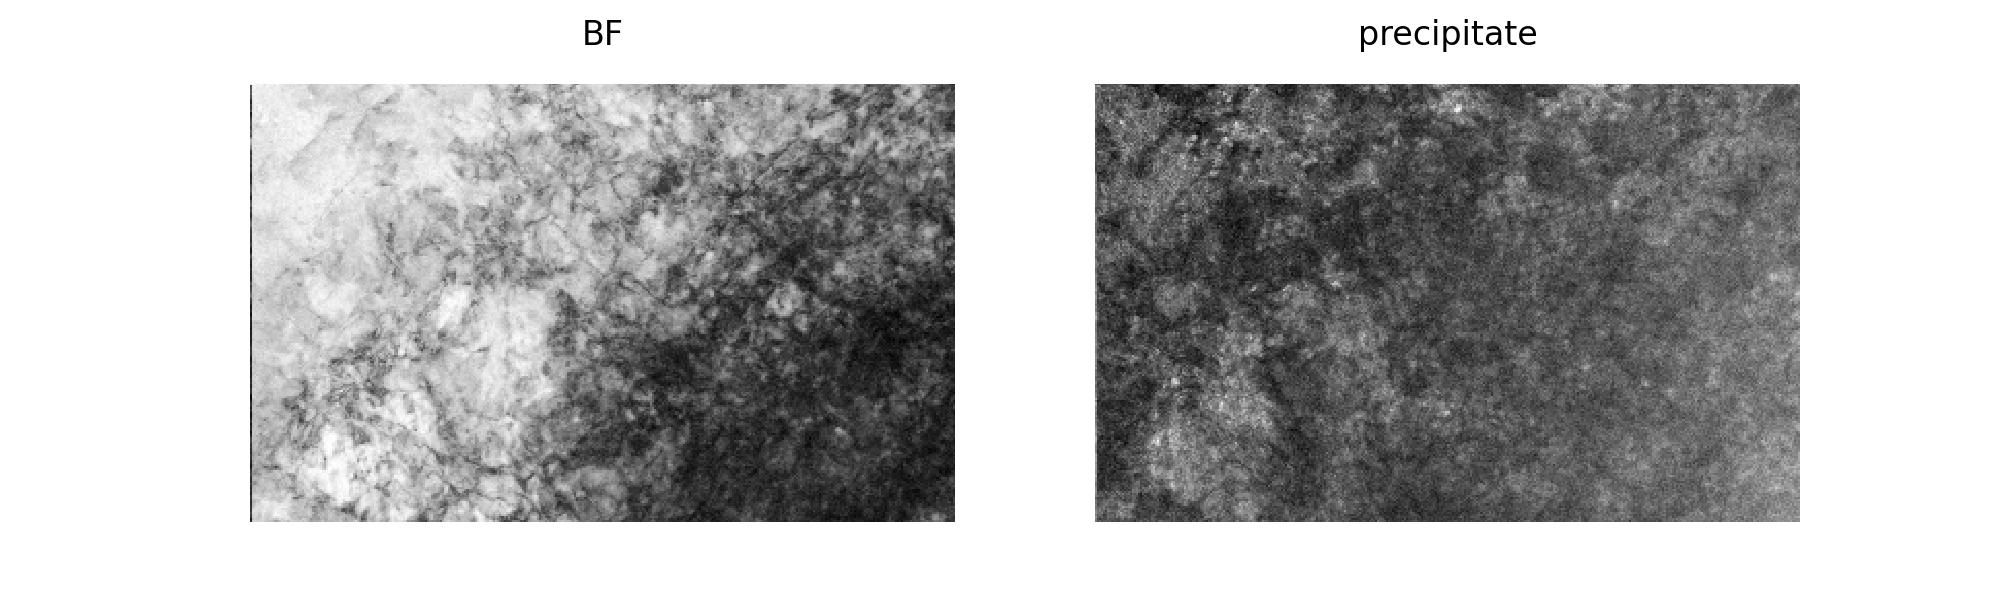

In [37]:
#compare conventional BF and precipitate

fig,ax=plt.subplots(ncols=2, figsize=(10,3))
ax[0].matshow(BF, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('BF')

ax[1].matshow(ppt, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('precipitate')

plt.show()

<IPython.core.display.Javascript object>


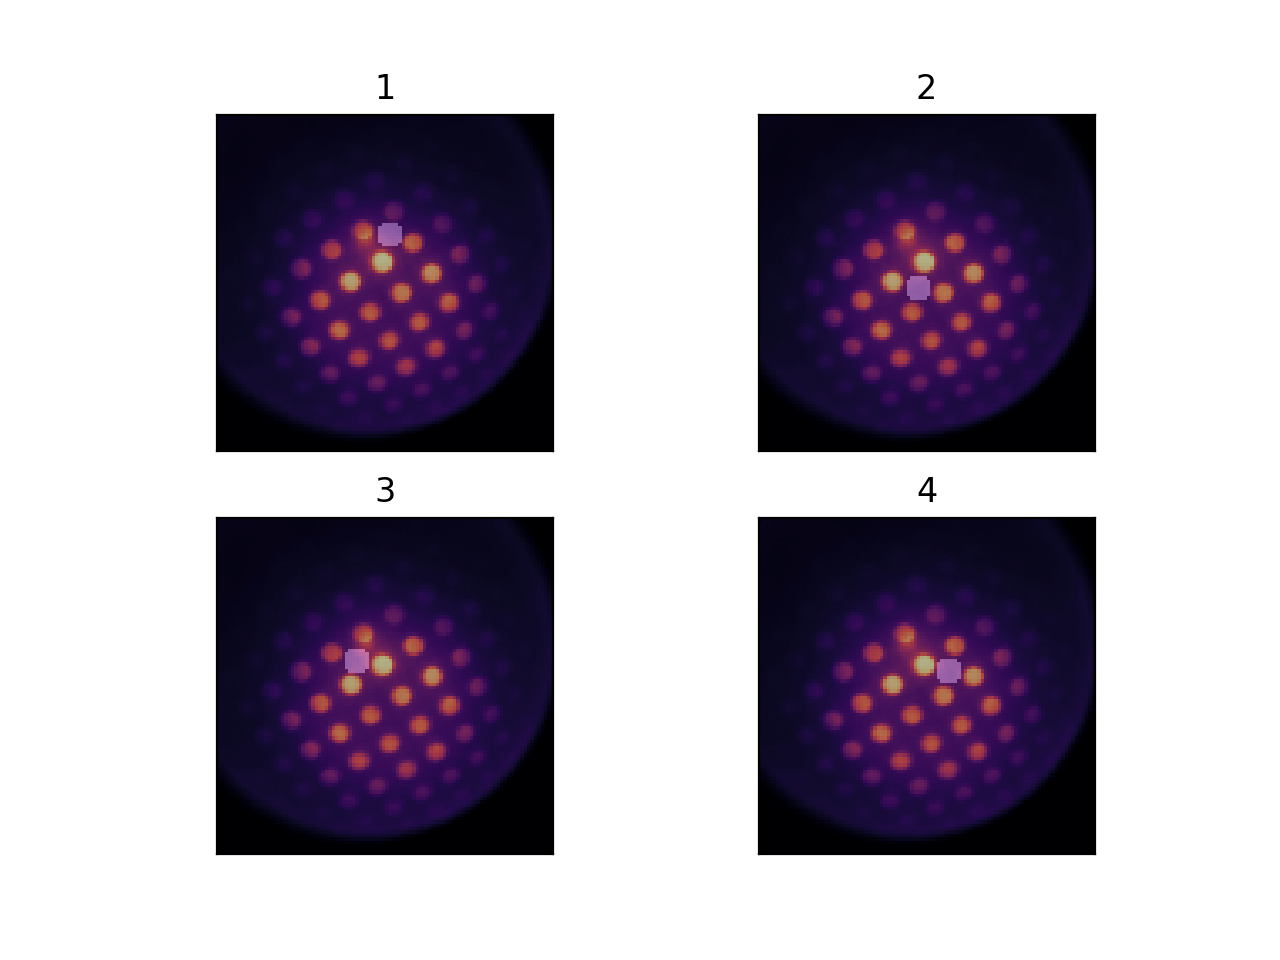

In [15]:
#check all ppt reflection

x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_ppt1 = (x - 35) ** 2 + (y-51) ** 2 < 4 ** 2
mask_ppt2 = (x - 51) ** 2 + (y-47) ** 2 < 4 ** 2
mask_ppt3 = (x - 42) ** 2 + (y-41) ** 2 < 4 ** 2
mask_ppt4 = (x - 45) ** 2 + (y-56) ** 2 < 4 ** 2

ppt1=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))
ppt2=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))
ppt3=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))
ppt4=np.zeros((virtualimage.shape[0],virtualimage.shape[1]))

for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_ppt1[i,j]:
            ppt1=ppt1+data[:,:,i,j]
        if mask_ppt2[i,j]:
            ppt2=ppt2+data[:,:,i,j]
        if mask_ppt3[i,j]:
            ppt3=ppt3+data[:,:,i,j]
        if mask_ppt4[i,j]:
            ppt4=ppt4+data[:,:,i,j]
            
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(aveDP, cmap='magma')
ax[0,0].imshow(mask_ppt1, cmap='gray', alpha=0.3)
ax[0,0].set_title('1')

ax[0,1].imshow(aveDP, cmap='magma')
ax[0,1].imshow(mask_ppt2, cmap='gray', alpha=0.3)
ax[0,1].set_title('2')

ax[1,0].imshow(aveDP, cmap='magma')
ax[1,0].imshow(mask_ppt3, cmap='gray', alpha=0.3)
ax[1,0].set_title('3')

ax[1,1].imshow(aveDP, cmap='magma')
ax[1,1].imshow(mask_ppt4, cmap='gray', alpha=0.3)
ax[1,1].set_title('4')

for axss in ax.flatten():
    axss.set_yticks([])
    axss.set_xticks([])

plt.show()

<IPython.core.display.Javascript object>


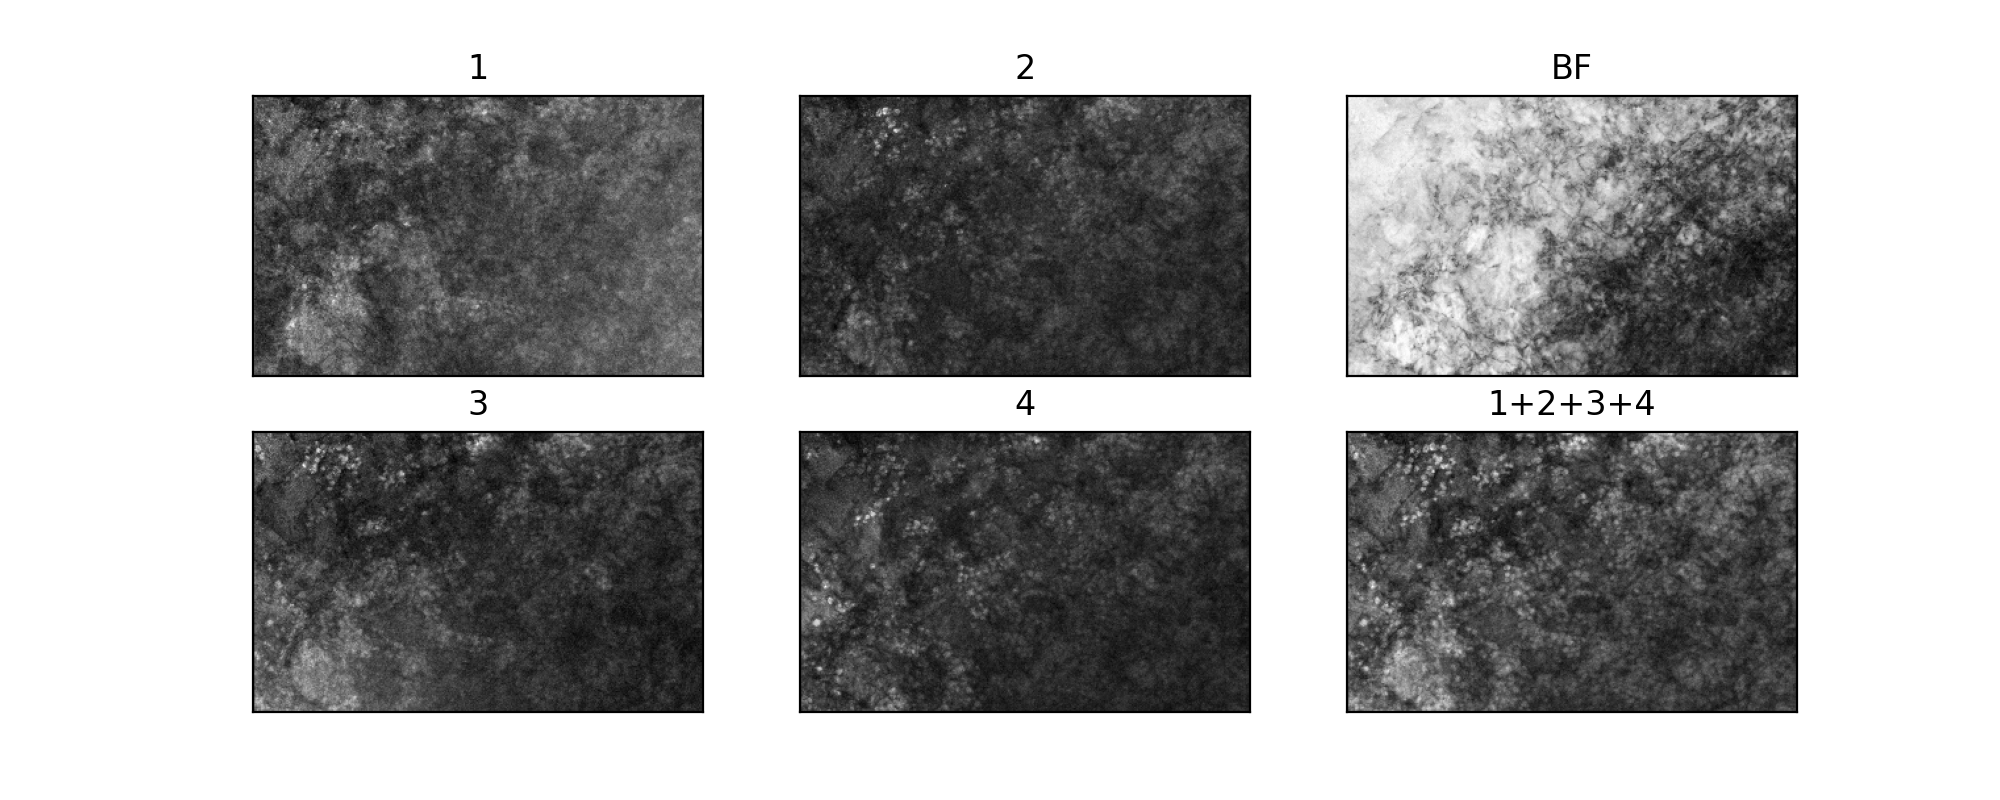

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,4))
ax[0,0].imshow(ppt1, cmap='gray')
ax[0,0].set_title('1')

ax[0,1].imshow(ppt2, cmap='gray')
ax[0,1].set_title('2')

ax[1,0].imshow(ppt3, cmap='gray')
ax[1,0].set_title('3')

ax[1,1].imshow(ppt4, cmap='gray')
ax[1,1].set_title('4')

ax[0,2].imshow(BF, cmap='gray')
ax[0,2].set_title('BF')

pptsum=ppt1+ppt2+ppt3+ppt4

ax[1,2].imshow(pptsum, cmap='gray')
ax[1,2].set_title('1+2+3+4')

for axss in ax.flatten():
    axss.set_yticks([])
    axss.set_xticks([])

plt.show()

<IPython.core.display.Javascript object>


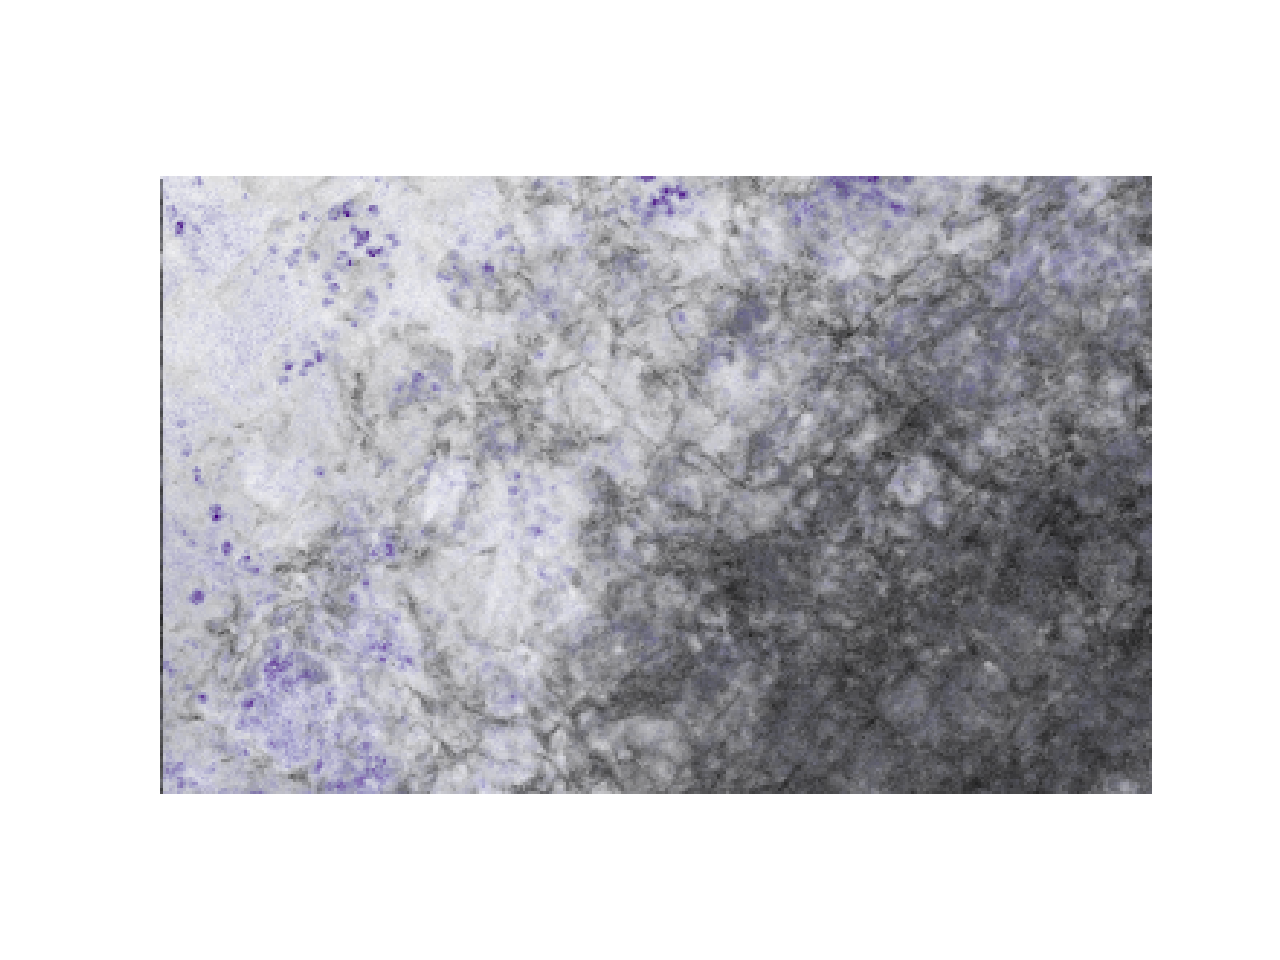

In [17]:
#colormaps: https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
#make your own color map with transparent instead of white as lower bound                
cmap = plt.cm.Purples
my_purple = cmap(np.arange(cmap.N))
my_purple[:,-1] = np.linspace(0, 1, cmap.N)
my_purple = ListedColormap(my_purple)

#plot precipitate on top of matrix using new colormap 
fig,ax = plt.subplots()
ax.matshow(BF, cmap = "gray")
ax.matshow(pptsum, cmap = my_purple)

ax.axis('off')

plt.show()

### 4. Performing advanced analysis 
- Scanning diffraction datasets contain rich chemical and physical information about your specimen.
- Reconstruction techniques include DPC, signal enhancement, displacement/strain/stress analysis, ptychography to name a few.
- Here we will begin to look at rotation. There is significant opportunity to expand this code and modify for specific dataset.

<IPython.core.display.Javascript object>


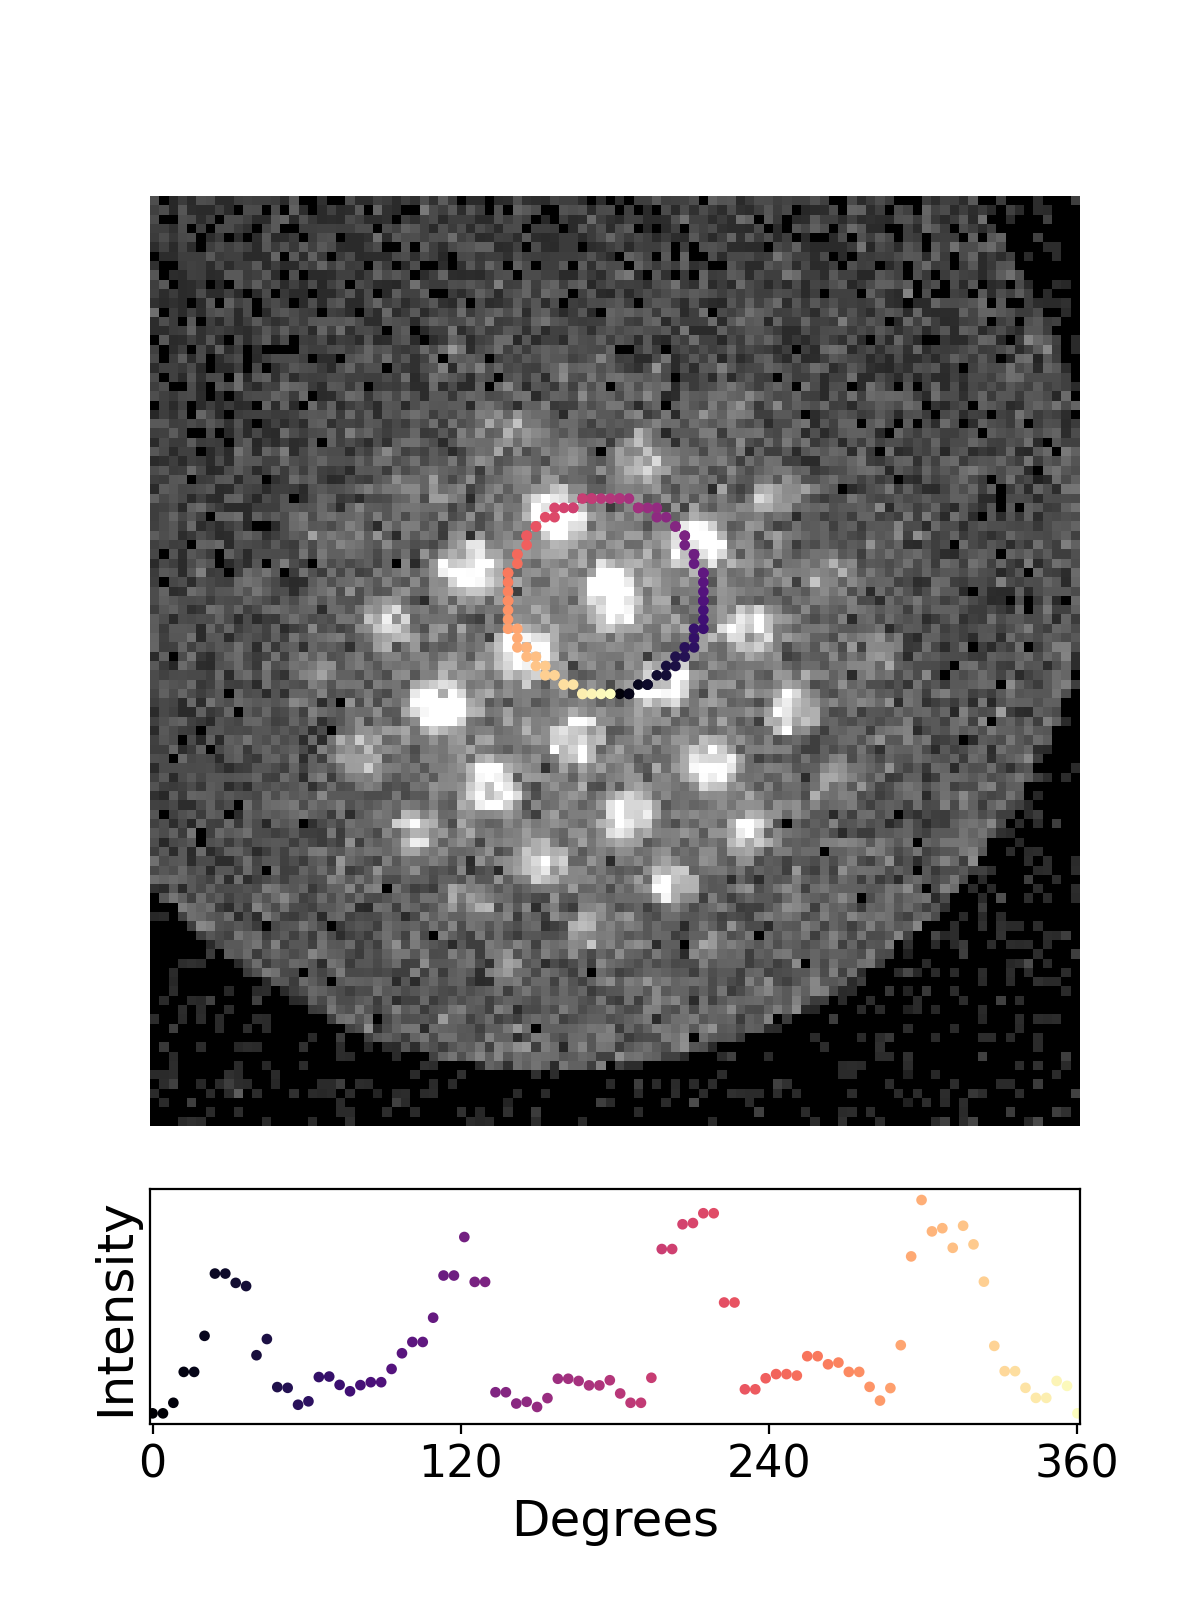

In [18]:
i=30
j=220

testDP=data[i,j,:,:]

n_dots = 90   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots) # angles to the dots
cx, cy = (ic, jc)  # center of circle
ra = 10.5 #radius

#initalize dot vectors
xs=[]
ys=[]

for ang in angs:
    # compute (x,y) for each point
    x = cx + ra*np.cos(ang)
    y = cy + ra*np.sin(ang)
    xs.append(x)   # collect x
    ys.append(y)   # collect y

#convert to integer numpy array so values can be used for indexing in for loop
xs=np.asarray(xs).astype(int)
ys=np.asarray(ys).astype(int)

#extract intensity at dots
zi=np.zeros((1,len(angs)))
for ii in range(0,len(angs)):
    #extract intensity around circle
    #zi[0,ii] = testDP[xs[ii], ys[ii]] 
    #use local averaging in diffraction space to smooth curve
    zi[0,ii] = np.average(testDP[xs[ii][0]-1:xs[ii][0]+1, ys[ii][0]-1:ys[ii][0]+1])

#create vector to plot against intensities    
x_axis=n_dots = np.linspace(0, 360, n_dots)

    
fig = plt.figure(figsize=(6,8))

#gridspec can be used for fancy plotting
gs0 = gridspec.GridSpec(2, 1, height_ratios=[4,1], wspace=0.03, hspace=0.1)
ax1 = plt.subplot(gs0[0, 0])
ax2 = plt.subplot(gs0[1,0])
    
#plot DP and show dot location
ax1.matshow(testDP**0.5, cmap=plt.cm.gray)
ax1.scatter(ys, xs, c=angs, cmap='magma', s=8)
ax1.axis('off')


ax2.scatter(x_axis, zi[0,:], c=angs, cmap='magma', s=8)
ax2.set_yticks([])
ax2.set_xticks([0,120,240,360])
ax2.set_xlim([-1,361])
ax2.set_ylabel("Intensity", fontsize=18)
ax2.set_xlabel("Degrees", fontsize=18)
ax2.tick_params(axis='x', labelsize=16)

plt.show()

In [19]:
#apply to entire data set, find maximum point 

#initalize vectors
peak_max=np.zeros((data.shape[0],data.shape[1]))
remain=np.zeros((data.shape[0],data.shape[1]))

for i in range(0,data.shape[0]):
        for j in range(0,data.shape[1]): 
            testDP=data[i,j,:,:]
            
            #find values around circle
            zi=np.zeros((1,len(xs)))
            for ii in range(0,len(xs)):
                    zi[0,ii] = np.average(testDP[xs[ii][0]-1:xs[ii][0]+1, ys[ii][0]-1:ys[ii][0]+1])
            
            #find maximum value
            max_loc=np.argmax(zi)
            peak_max[i,j]=max_loc
            #divide to account for 4-fold symmetry
            remain[i,j]=max_loc%22.5

In [20]:
fig,ax = plt.subplots(ncols=3, figsize=(10,4))
map1=ax[0].imshow(peak_max, cmap="magma", vmin=0, vmax=90)  
ax[0].set_title('location of max')
cbar=fig.colorbar(map1, ax=ax[0], fraction=0.05)


map2=ax[1].imshow(remain, cmap="magma", vmin=0, vmax=22.5)  
ax[1].set_title('location of max \n divided by 4')
cbar=fig.colorbar(map2, ax=ax[1], fraction=0.04)


ax[2].matshow(BF, cmap = "gray")
ax[2].matshow(pptsum, cmap = my_purple)
ax[2].set_title('BF')

for axss in ax.flatten():
    axss.set_yticks([])
    axss.set_xticks([])

plt.show()

<IPython.core.display.Javascript object>

In [21]:
#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)

#rotate point by 90° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))


xa, ya = 83, 74 #point for creating detectors, this can be modified to rotate detectors

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

aa=20 #outside of detector
bb=8 #inside of detector

#create masks
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < aa ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > bb ** 2

mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask1 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask1_COM=ndimage.measurements.center_of_mass(mask1)


mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask2 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask2_COM=ndimage.measurements.center_of_mass(mask2)

mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask3_COM=ndimage.measurements.center_of_mass(mask3)


mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask4 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask4_COM=ndimage.measurements.center_of_mass(mask4)

#create black/white colormap with transparent value 
cmap = plt.cm.binary
my_binary = cmap(np.arange(cmap.N))
my_binary[:,-1] = np.linspace(0, 1, cmap.N)
my_binary = ListedColormap(my_binary)

#plot masks
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(mask1, alpha=1, cmap=my_binary)
ax.imshow(mask2, alpha=0.8, cmap=my_binary)
ax.imshow(mask3, alpha=0.65, cmap=my_binary)
ax.imshow(mask4, alpha=0.5, cmap=my_binary)

#add labels
ax.text(mask1_COM[1],mask1_COM[0], '1', ha='center',fontweight='bold', fontsize=16, color='white')
ax.text(mask2_COM[1],mask2_COM[0],'2', ha='center', fontweight='bold', fontsize=16, color='white')
ax.text(mask3_COM[1],mask3_COM[0],'3', ha='center', fontweight='bold', fontsize=16, color='white')
ax.text(mask4_COM[1],mask4_COM[0],'4', ha='center', fontweight='bold', fontsize=16, color='white')

ax.imshow(aveDP**0.4, cmap=plt.cm.magma, alpha=0.7)

ax.axis('off')
plt.show()

#check masks are of equal size
print('number of elements in mask1 is ' + str(mask1.sum()))
print('number of elements in mask2 is ' + str(mask2.sum()))
print('number of elements in mask3 is ' + str(mask3.sum()))
print('number of elements in mask4 is ' + str(mask4.sum()))

<IPython.core.display.Javascript object>

number of elements in mask1 is 262
number of elements in mask2 is 262
number of elements in mask3 is 262
number of elements in mask4 is 262


In [22]:
#reconstruct images from quadrant detectors

#initialize
int_mask1=np.zeros((data.shape[0],data.shape[1]))
int_mask2=np.zeros((data.shape[0],data.shape[1]))
int_mask3=np.zeros((data.shape[0],data.shape[1]))
int_mask4=np.zeros((data.shape[0],data.shape[1]))

#integrate
for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if mask1[i,j]:
                int_mask1=int_mask1+data[:,:,i,j]
            if mask2[i,j]:
                int_mask2=int_mask2+data[:,:,i,j]
            if mask3[i,j]:
                int_mask3=int_mask3+data[:,:,i,j]
            if mask4[i,j]:
                int_mask4=int_mask4+data[:,:,i,j]
        

In [23]:
#check min and max, so reconstructions can be plotted on same scale

print(np.max((int_mask1-int_mask3)/(int_mask1+int_mask3)))
print(np.max((int_mask2-int_mask4)/(int_mask2+int_mask4)))

print(np.min((int_mask1-int_mask3)/(int_mask1+int_mask3)))
print(np.min((int_mask2-int_mask4)/(int_mask2+int_mask4)))

0.45046138902379795
0.49478558403507694
-0.45565478387088837
-0.20571585326317365


<IPython.core.display.Javascript object>


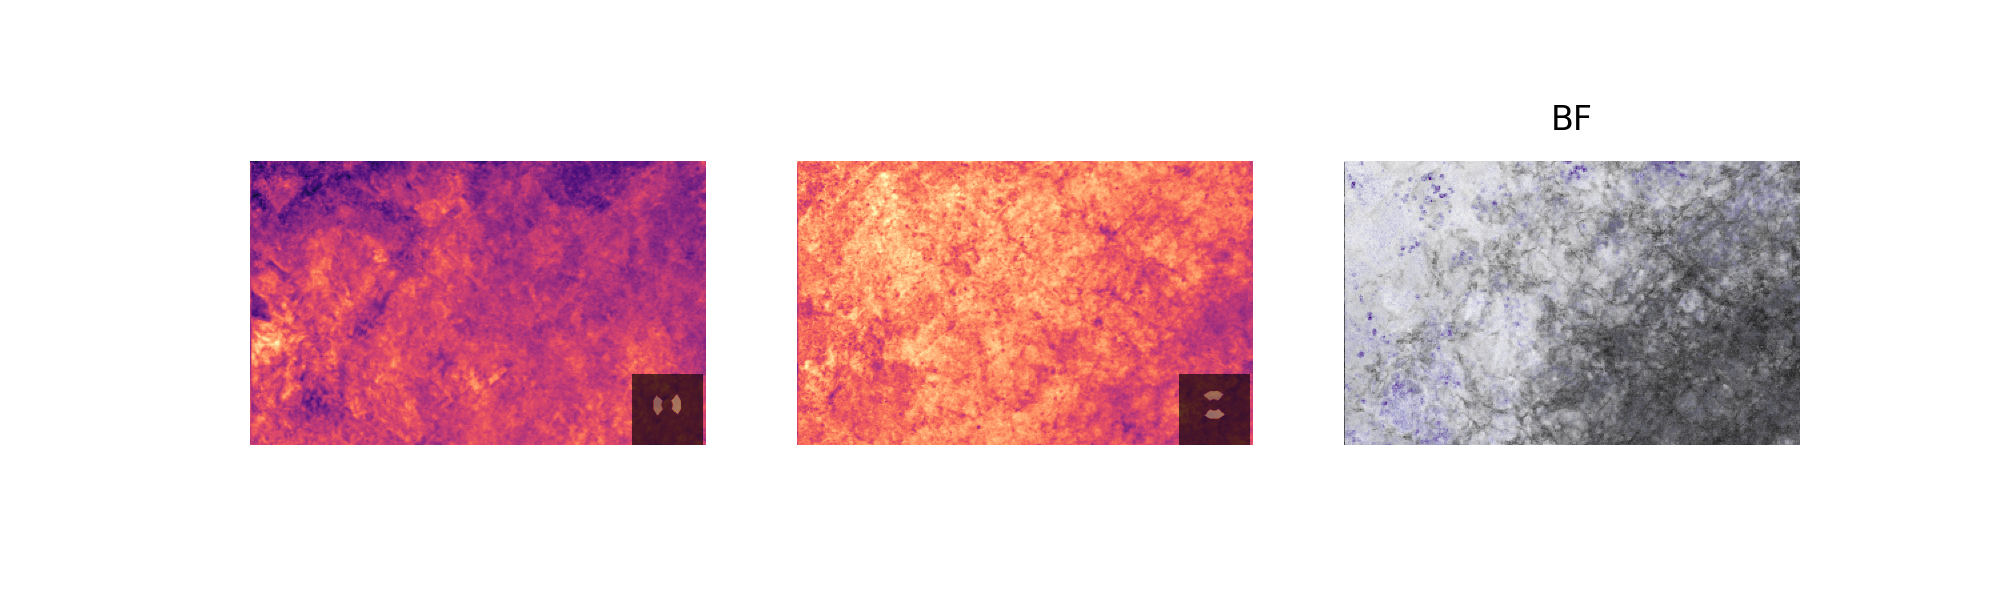

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))

ax[0].imshow((int_mask1-int_mask3)/(int_mask1+int_mask3), cmap=plt.cm.magma, vmax=0.49, vmin=-0.46)
ins = ax[0].inset_axes([0.79,0,0.25,0.25]) #add inset to show detectos 
ins.imshow(mask1, cmap=plt.cm.inferno, alpha=0.5)
ins.imshow(mask3, cmap=plt.cm.inferno, alpha=0.3)
ax[0].axis('off')
ins.axis('off')

ax[1].imshow((int_mask2-int_mask4)/(int_mask2+int_mask4), cmap=plt.cm.magma, vmax=0.49, vmin=-0.46)
ins = ax[1].inset_axes([0.79,0,0.25,0.25])
ins.imshow(mask2, cmap=plt.cm.inferno, alpha=0.5)
ins.imshow(mask4, cmap=plt.cm.inferno, alpha=0.3)
ax[1].axis('off')
ins.axis('off')


ax[2].matshow(BF, cmap = "gray")
ax[2].matshow(pptsum, cmap = my_purple)
ax[2].set_title('BF')
ax[2].axis('off')

plt.show()